In [1]:
%load_ext autoreload
%autoreload 2


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.utils import label, author_data, sample_submission, train, test, features_author

In [2]:
features_author

Index(['engagement', 'timestamp', 'language', 'feature1', 'feature2',
       'followers', 'author', 'word_count', 'shared_url_count',
       'shared_url_domain', 'is_reply', 'is_retweet', 'contains_video',
       'contains_image'],
      dtype='object')

#### Optimize with a constant guess

In [6]:
from scipy.optimize import minimize
def cost_mae(x):
    return np.abs(author_data.engagement - x).mean()
minimize(cost_mae, 0)

      fun: 1502.9885517331204
 hess_inv: array([[41.64743162]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 108
      nit: 5
     njev: 54
   status: 0
  success: True
        x: array([6.99999999])

In [8]:
def cost_mae_train(x):
    return np.abs(train.engagement - x).mean()
minimize(cost_mae_train, 0)

      fun: 19266.483156881553
 hess_inv: array([[4945.7075919]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 26
      nit: 10
     njev: 13
   status: 0
  success: True
        x: array([486.46029153])

In [10]:
sample_submission.engagement = 7
sample_submission.to_csv("output/constant_output.csv", index=False)

#### Label description

In [4]:
author_data.engagement.describe()

count    6.298770e+05
mean     1.503918e+03
std      1.192076e+04
min      0.000000e+00
25%      0.000000e+00
50%      7.000000e+00
75%      1.720000e+02
max      1.328027e+06
Name: engagement, dtype: float64

In [3]:
train.engagement.describe()

count    4.156000e+03
mean     1.934010e+04
std      7.004105e+04
min      0.000000e+00
25%      1.200000e+01
50%      4.870000e+02
75%      6.848750e+03
max      1.298512e+06
Name: engagement, dtype: float64

#### Choose features according to their importance (RFE)

In [9]:
%%time
from sklearn.feature_selection import RFE
from lightgbm import LGBMRegressor
selector = RFE(LGBMRegressor(num_leaves=10, 
                max_depth=5, 
                learning_rate=0.07, 
                objective="mae",
                random_state=0),
               n_features_to_select=5, 
               step=3,
               verbose=1,
   )
selector.fit(train.drop(columns=["engagement" ,"language", "shared_url_domain", "author"]), train.engagement)

Fitting estimator with 1034 features.
Fitting estimator with 1031 features.
Fitting estimator with 1028 features.
Fitting estimator with 1025 features.
Fitting estimator with 1022 features.
Fitting estimator with 1019 features.
Fitting estimator with 1016 features.
Fitting estimator with 1013 features.
Fitting estimator with 1010 features.
Fitting estimator with 1007 features.
Fitting estimator with 1004 features.
Fitting estimator with 1001 features.
Fitting estimator with 998 features.
Fitting estimator with 995 features.
Fitting estimator with 992 features.
Fitting estimator with 989 features.
Fitting estimator with 986 features.
Fitting estimator with 983 features.
Fitting estimator with 980 features.
Fitting estimator with 977 features.
Fitting estimator with 974 features.
Fitting estimator with 971 features.
Fitting estimator with 968 features.
Fitting estimator with 965 features.
Fitting estimator with 962 features.
Fitting estimator with 959 features.
Fitting estimator with 956

Fitting estimator with 368 features.
Fitting estimator with 365 features.
Fitting estimator with 362 features.
Fitting estimator with 359 features.
Fitting estimator with 356 features.
Fitting estimator with 353 features.
Fitting estimator with 350 features.
Fitting estimator with 347 features.
Fitting estimator with 344 features.
Fitting estimator with 341 features.
Fitting estimator with 338 features.
Fitting estimator with 335 features.
Fitting estimator with 332 features.
Fitting estimator with 329 features.
Fitting estimator with 326 features.
Fitting estimator with 323 features.
Fitting estimator with 320 features.
Fitting estimator with 317 features.
Fitting estimator with 314 features.
Fitting estimator with 311 features.
Fitting estimator with 308 features.
Fitting estimator with 305 features.
Fitting estimator with 302 features.
Fitting estimator with 299 features.
Fitting estimator with 296 features.
Fitting estimator with 293 features.
Fitting estimator with 290 features.
F

RFE(estimator=LGBMRegressor(learning_rate=0.07, max_depth=5, num_leaves=10,
                            objective='mae', random_state=0),
    n_features_to_select=5, step=3, verbose=1)

In [10]:
print(selector.support_)
print(selector.ranking_)

[ True False False ... False False False]
[  1  82  41 ... 336 342 343]


In [13]:
train.drop(columns=["engagement" ,"language", "shared_url_domain", "author"]).iloc[:, selector.support_]

,timestamp,followers,is_reply,V8,V266
0,1655784230254,696,False,0.086126,0.052564
1,1655599613254,17526,False,0.075310,0.071889
2,1655788872254,239,True,0.067732,0.031401
3,1655788810254,21531,False,0.095869,0.030384
4,1655789250254,101278,False,0.064887,0.065653
...,...,...,...,...,...
4151,1655757328254,8781,False,0.079026,0.063873
4152,1655789504254,1347,False,0.007193,0.051595
4153,1655789228254,2299,False,0.071753,0.011959
4154,1655772495254,143736,False,0.097763,0.051059


In [18]:
train.drop(columns=["engagement" ,"language", "shared_url_domain", "author"]).iloc[:, selector.ranking_ < 5].columns

Index(['timestamp', 'followers', 'shared_url_count', 'is_reply', 'V8', 'V258',
       'V266', 'V456', 'V479', 'V582', 'V632', 'V687', 'V716', 'V915'],
      dtype='object')

In [19]:
len(['timestamp', 'followers', 'shared_url_count', 'is_reply', 'V8', 'V258',
       'V266', 'V456', 'V479', 'V582', 'V632', 'V687', 'V716', 'V915'])

14

## We start with one author

In [1]:
# Time stamp is important!!!

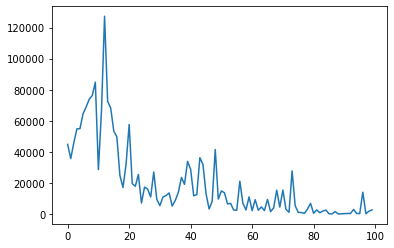

In [28]:
train["cut_timestamp"] = pd.qcut(train["timestamp"], q=100, labels=False)
plt.plot(train.groupby("cut_timestamp").mean()["engagement"])

In [16]:
author_data["cut_timestamp"] = pd.qcut(author_data["timestamp"], q=100, labels=False)

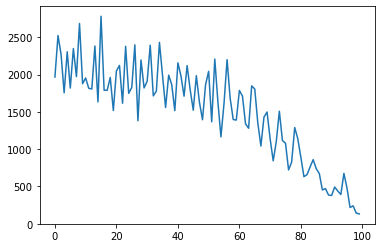

In [24]:
plt.plot(author_data.groupby("cut_timestamp").mean()["engagement"])
#.plot(logy=True)

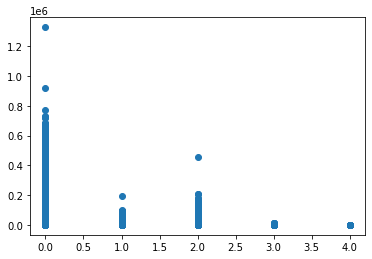

In [8]:
plt.scatter(author_data.shared_url_count, author_data.engagement)

In [3]:
author_data.groupby("author").count().engagement.describe()

count    8126.000000
mean       77.513783
std        32.908481
min         1.000000
25%        60.000000
50%        97.000000
75%        99.000000
max       100.000000
Name: engagement, dtype: float64

In [12]:
sample_author = train["author"].iloc[0]
author_loc = author_data[author_data["author"] == sample_author]
sample_author

'bd20432d80dfe4825a7a106312bda52e'

In [13]:
author_loc

,engagement,timestamp,language,feature1,feature2,followers,author,word_count,shared_url_count,shared_url_domain,is_reply,is_retweet,contains_video,contains_image
17658,8,1654378174254,en,100,0,652,bd20432d80dfe4825a7a106312bda52e,52,1,http://independent.co.uk/,True,False,False,False
39581,10,1654223425254,en,100,-5,650,bd20432d80dfe4825a7a106312bda52e,13,1,http://independent.co.uk/,True,False,False,False
54381,17,1654199136254,en,100,0,650,bd20432d80dfe4825a7a106312bda52e,33,1,http://independent.co.uk/,False,False,False,False
58096,8,1653984741254,en,100,-5,641,bd20432d80dfe4825a7a106312bda52e,36,1,http://independent.co.uk/,True,False,False,False
59699,11,1655007721254,en,100,5,675,bd20432d80dfe4825a7a106312bda52e,16,1,http://independent.co.uk/,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592800,85,1654622600254,en,100,0,666,bd20432d80dfe4825a7a106312bda52e,37,1,http://independent.co.uk/,False,False,False,False
600089,16,1655437874254,en,100,-5,673,bd20432d80dfe4825a7a106312bda52e,33,1,http://independent.co.uk/,True,False,False,False
603200,17,1655144760254,en,100,-5,674,bd20432d80dfe4825a7a106312bda52e,21,1,http://independent.co.uk/,True,False,False,False
614394,10,1655633624254,en,100,0,680,bd20432d80dfe4825a7a106312bda52e,37,1,http://independent.co.uk/,False,False,False,False


In [47]:
train[train["author"] == sample_author]

,engagement,timestamp,language,feature1,feature2,followers,author,word_count,shared_url_count,shared_url_domain,...,V1015,V1016,V1017,V1018,V1019,V1020,V1021,V1022,V1023,V1024
0,15,1655784230254,en,73,0,696,bd20432d80dfe4825a7a106312bda52e,18,0,NaN,...,0.066302,-0.002309,0.006296,-0.003366,0.055845,0.002813,0.03093,0.040009,0.017094,0.047829


#### Engagements in author_data.

In [46]:
i = 0
author_loc[features_author[i]].describe()

count     99.000000
mean      29.969697
std       71.762428
min        6.000000
25%        8.000000
50%       14.000000
75%       25.500000
max      629.000000
Name: engagement, dtype: float64

We saw that the mean is not far from the label data. Perhaps a good feature

#### Language

In [22]:
i = 2
author_data[features_author[i]].value_counts(normalize=True)

en    0.936227
ja    0.009557
es    0.008281
pt    0.007908
id    0.005803
        ...   
ne    0.000002
my    0.000002
an    0.000002
vo    0.000002
mg    0.000002
Name: language, Length: 103, dtype: float64

For the language feature, it turns out that there are so many "en" and there might be a overfitting for the rest of data.

In [48]:
author_data.groupby("language").agg({label : "mean"}).max()#.corr()

engagement    16805.666667
dtype: float64

In [49]:
#author_data.groupby("language").agg({label : "mean"})
author_data[author_data["language"] == "pa"]

,engagement,timestamp,language,feature1,feature2,followers,author,word_count,shared_url_count,shared_url_domain,is_reply,is_retweet,contains_video,contains_image
129487,0,1655644338254,pa,100,0,249,1a43f9c65c1722681b2379fab82202af,3,0,NaN,True,False,False,False
496891,50417,1653849741254,pa,100,0,50266014,18b7595935a34f3eae034c1d4b0ed310,28,0,NaN,False,False,False,True
512848,0,1655647995254,pa,100,0,447,9a73bd07722bf3d483bb8df4474dad4d,2,0,NaN,True,False,False,False


A typical overfitting. In this case, [language == "pa"] will biased the rest 0-valued engagements.

#### Feature1

In [51]:
i = 3
author_data[features_author[i]].describe()

count    629877.000000
mean         65.995596
std          38.965414
min           0.000000
25%          29.000000
50%          88.000000
75%         100.000000
max         100.000000
Name: feature1, dtype: float64

Feature1 is a value from 0 to 100. Is there any correlation?

In [53]:
author_data[[label, features_author[i]]].corr()

,engagement,feature1
engagement,1.000000,-0.003794
feature1,-0.003794,1.000000


No

#### Feature2

In [57]:
i = 4
author_data[features_author[i]].describe()

count    629877.000000
mean         -0.324936
std           3.454138
min          -5.000000
25%          -5.000000
50%           0.000000
75%           0.000000
max           5.000000
Name: feature2, dtype: float64

Feature2 is a value from -5 to 5. Is there any correlation?

In [58]:
author_data[[label, features_author[i]]].corr()

,engagement,feature2
engagement,1.000000,-0.007886
feature2,-0.007886,1.000000


No, neither

#### Followers

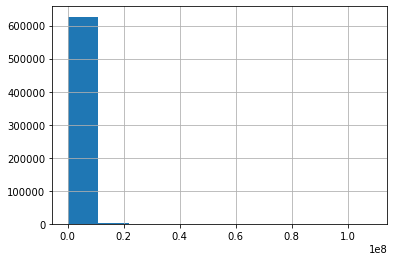

In [60]:
i = 5
author_data[features_author[i]].hist()

We have some outliers for the number of the followers

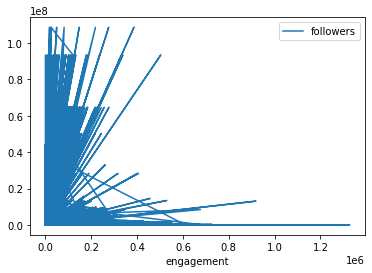

In [64]:
i=5
author_data[[label, features_author[i]]].plot(x=label)

In [75]:
author_data[[label, "followers"]].corr()

,engagement,followers
engagement,1.000000,0.191313
followers,0.191313,1.000000


We are gonna cut the number of followers by the quantile among all and then compared it to our label.

In [93]:
q = 100
print(q, 
      pd.concat([author_data.engagement, pd.qcut(author_data["followers"], 
                                                 q=q, 
                                                 labels=False)
                ], 
                axis=1, 
               ).corr().iloc[0, 1])

100 0.16261595132513765


With quantile, we might have less correlation but we can neglect the outliers.

In [63]:
author_data

,engagement,timestamp,language,feature1,feature2,followers,author,word_count,shared_url_count,shared_url_domain,is_reply,is_retweet,contains_video,contains_image
0,0,1655713481254,en,100,0,999,d2e03f4b7a57a6828392a80b6d8667c3,25,0,NaN,False,True,True,False
1,0,1655743160254,en,100,-5,5,5622c71671e9b0ab9052fd574876b46d,9,0,NaN,False,False,False,False
2,3486,1655395750254,en,100,-5,454592,9b72b401edaf6aec6603856a3a6fb050,45,0,NaN,False,False,False,False
3,7,1654621088254,ar,100,5,19348,dc3d6148b435c40a4e75e7d6b5bd22c9,10,0,NaN,False,False,False,False
4,0,1655754531254,en,45,-5,973,0e47c55a7918dd9130da37a80e46a2e0,14,0,NaN,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629872,479,1655694387254,en,100,0,129015,b0727df747f870315a651ce8864023a1,23,0,NaN,False,False,False,False
629873,161,1653691877254,en,4,0,27467,be2260a0684d01ec8567f73ef9650277,11,0,NaN,False,False,True,False
629874,0,1655766485254,en,94,5,401,012777f856a2162bb318ae7c15e2d280,19,0,NaN,False,True,False,False
629875,0,1655618304254,en,35,0,305008,5fd84f30702e9d0ab236e44a8328ae30,18,0,NaN,False,True,False,False




#### Word_count

In [94]:
author_data[[label, "word_count"]].corr()

,engagement,word_count
engagement,1.000000,0.006949
word_count,0.006949,1.000000
